# Spatial Exploratory Analysis

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import seaborn as sns
import re
import libpysal
from esda import Moran, Moran_Local

In [3]:
# --- 1. Carregar shapefile da Área Metropolitana do Porto ---
shapefile_path = "C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/1_data_collection/spatial_data_AMP/shape_mun_AMP.shp"
amp_gdf = gpd.read_file(shapefile_path)

In [4]:
# Load the datasets
comments_df = pd.read_csv("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/2_pre_processing_NLP/comments_clean.csv")
ratings_df = pd.read_csv("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/2_pre_processing_NLP/ratings_clean.csv")

In [5]:
ratings_df.columns

Index(['Cidade', 'Categoria', 'Nome', 'Rating', 'Endereço', 'Tipos',
       'Latitude', 'Longitude', 'Total_Reviews', 'id_unico', 'Grupo_Tematico',
       'Locais_Semelhantes_Perto'],
      dtype='object')

In [6]:
# Inicializar o geocodificador
geolocator = Nominatim(user_agent="geo_amp_project")

# Adicionar pausa entre pedidos para respeitar os limites da API
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Criar colunas novas para latitude e longitude
ratings_df["Latitude_Nova"] = None
ratings_df["Longitude_Nova"] = None

# Aplicar geocoding (pode demorar!)
for idx, row in ratings_df.iterrows():
    try:
        location = geocode(row["Endereço"])
        if location:
            ratings_df.at[idx, "Latitude_Nova"] = location.latitude
            ratings_df.at[idx, "Longitude_Nova"] = location.longitude
    except Exception as e:
        print(f"Erro na linha {idx}: {e}")
        continue

RateLimiter caught an error, retrying (0/2 tries). Called with (*('R. 1º de Maio 4, 4540-113 Arouca, Portugal',), **{}).
Traceback (most recent call last):
  File "c:\Users\Fernanda Costa\.conda\envs\seminario\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "c:\Users\Fernanda Costa\.conda\envs\seminario\Lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Fernanda Costa\.conda\envs\seminario\Lib\http\client.py", line 1428, in getresponse
    response.begin()
  File "c:\Users\Fernanda Costa\.conda\envs\seminario\Lib\http\client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Fernanda Costa\.conda\envs\seminario\Lib\http\client.py", line 292, in _read_status
    line = str(self.f

In [7]:
# --- 2. Transformar ratings_df num GeoDataFrame com pontos ---
# Certificar que as colunas têm nome 'Latitude_Nova' e 'Longitude_Nova'
ratings_df['Latitude_Nova'] = pd.to_numeric(ratings_df['Latitude_Nova'], errors='coerce')
ratings_df['Longitude_Nova'] = pd.to_numeric(ratings_df['Longitude_Nova'], errors='coerce')

geometry = [Point(xy) for xy in zip(ratings_df['Longitude_Nova'], ratings_df['Latitude_Nova'])]
ratings_gdf = gpd.GeoDataFrame(ratings_df, geometry=geometry, crs="EPSG:4326")  # WGS84

In [8]:
# --- 3. Garantir que ambos os GeoDataFrames estão no mesmo sistema de coordenadas ---
amp_gdf = amp_gdf.to_crs("EPSG:4326")

In [9]:
# --- 4. Filtrar os pontos dentro dos limites da AMP ---
ratings_gdf = ratings_gdf[ratings_gdf.geometry.within(amp_gdf.unary_union)]

C:\Users\Fernanda Costa\AppData\Local\Temp\ipykernel_17436\1247618024.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ratings_gdf = ratings_gdf[ratings_gdf.geometry.within(amp_gdf.unary_union)]


<Figure size 1000x1000 with 0 Axes>

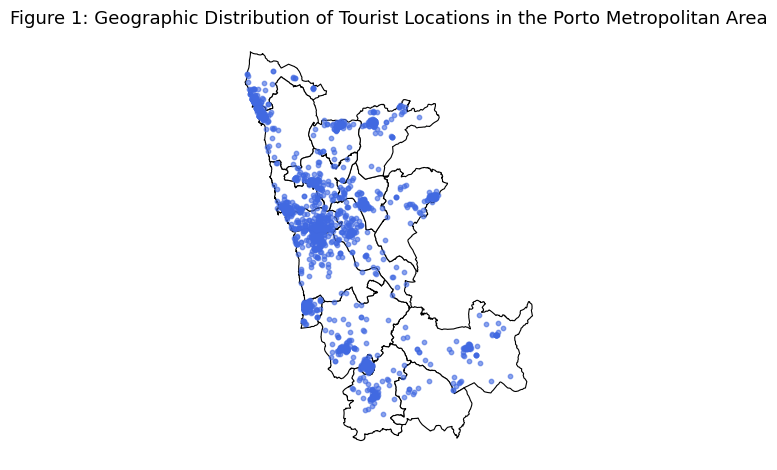

In [10]:
# --- 5. Plotar o mapa ---
plt.figure(figsize=(10, 10))
base = amp_gdf.plot(color='white', edgecolor='black', linewidth=0.8)
ratings_gdf.plot(ax=base, markersize=10, color='royalblue', alpha=0.6)

plt.title("Figure 1: Geographic Distribution of Tourist Locations in the Porto Metropolitan Area", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()

In [11]:
# Garantir que ambos estão no mesmo CRS (coordenadas geográficas)
ratings_gdf = ratings_gdf.set_crs("EPSG:4326")
amp_gdf = amp_gdf.to_crs("EPSG:4326")

# Spatial join: associar cada ponto ao município em que se insere
joined = gpd.sjoin(ratings_gdf, amp_gdf, how="inner", predicate="within")

# Contar número de locais por município
contagem_por_municipio = joined['Cidade'].value_counts().reset_index()
contagem_por_municipio.columns = ['Municipality', 'Number of Places']

# Mostrar resultados
contagem_por_municipio


Municipality  Number of Places
0                  Porto               214
1      Vila Nova de Gaia               211
2               Gondomar               187
3             Matosinhos               185
4                Espinho               173
5                   Maia               169
6        Póvoa de Varzim               164
7    São João da Madeira               123
8            Santo Tirso               121
9   Santa Maria da Feira               117
10                Arouca               116
11         Vila do Conde               114
12               Valongo               110
13   Oliveira de Azeméis                95
14                 Trofa                84
15               Paredes                83
16              Penafiel                 4

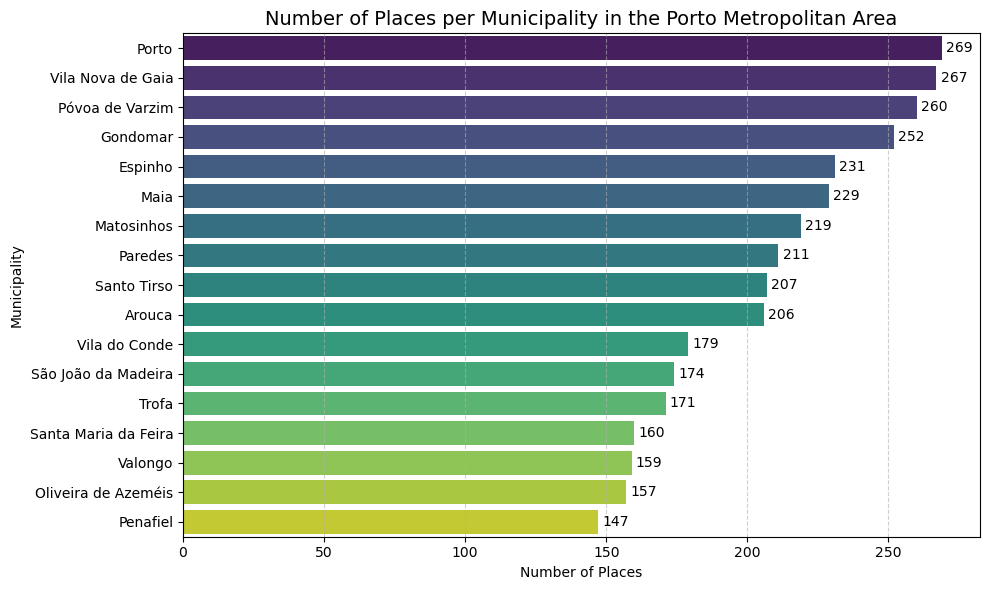

In [12]:
# Contar número de locais por cidade
locais_por_cidade = ratings_df['Cidade'].value_counts().sort_values(ascending=False).reset_index()
locais_por_cidade.columns = ['Municipality', 'Number of Places']

# Gráfico de barras horizontal com hue e sem legenda
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=locais_por_cidade,
    x='Number of Places',
    y='Municipality',
    hue='Municipality',        # necessário para usar palette
    palette="viridis",
    dodge=False,               # importante para não dividir barras por hue
    legend=False               # não mostrar legenda
)

# Adicionar rótulos a todas as barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.title("Number of Places per Municipality in the Porto Metropolitan Area", fontsize=14)
plt.xlabel("Number of Places")
plt.ylabel("Municipality")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [13]:
ratings_df['Endereço'].isna().sum()

0

In [14]:
# Locais cuja Cidade é "Porto"
porto_csv = ratings_df[ratings_df['Cidade'] == 'Porto']

# Locais que caem espacialmente dentro do município de Porto (via shapefile)
porto_spatial = joined[joined['Cidade'] == 'Porto']

# Diferença entre os dois conjuntos
print(f"Nº locais marcados como 'Porto' no CSV: {len(porto_csv)}")
print(f"Nº locais em 'Porto' segundo o shapefile: {len(porto_spatial)}")

Nº locais marcados como 'Porto' no CSV: 269
Nº locais em 'Porto' segundo o shapefile: 214


In [15]:
# Obter os ID únicos dos que estão realmente no Porto (via shapefile)
ids_porto_espacial = set(porto_spatial['id_unico'])

# Filtrar os que têm 'Porto' no CSV mas NÃO estão no polígono do Porto
porto_fora_poligono = porto_csv[~porto_csv['id_unico'].isin(ids_porto_espacial)]

# Ver alguns exemplos
porto_fora_poligono[['Nome', 'Endereço', 'Categoria', 'Latitude_Nova', 'Longitude_Nova']].head()

Nome  \
1652                                           The Door   
1653                                  Tapabento S.Bento   
1668                                  Culto ao Bacalhau   
1671                                 Cozinha das Flores   
1673  Do Norte Café by Hungry Biker | Brunch & Break...   

                                               Endereço   Categoria  \
1652   Rua das Taipas 94 a 96, 4050-598 Porto, Portugal  restaurant   
1653  Estação de S. Bento, ao lado da Linha 1, R. da...  restaurant   
1668  Piso Galeria, R. Formosa 322 Loja R8, 4000-248...  restaurant   
1671    Lgo de S. Domingos 62, 4050-545 Porto, Portugal  restaurant   
1673  Rua do Almada 57/59 4000, 4050-036 Porto, Port...  restaurant   

      Latitude_Nova  Longitude_Nova  
1652            NaN             NaN  
1653            NaN             NaN  
1668            NaN             NaN  
1671            NaN             NaN  
1673            NaN             NaN

In [16]:
# Filtrar linhas onde Latitude_Nova ou Longitude_Nova são nulas
sem_coordenadas = ratings_df[ratings_df['Latitude_Nova'].isna() | ratings_df['Longitude_Nova'].isna()]

# Mostrar todas as linhas filtradas
pd.set_option('display.max_rows', None)  # Mostrar todas as linhas (atenção se forem muitas)
sem_coordenadas[['Nome', 'Endereço', 'Latitude_Nova', 'Longitude_Nova']].head()

Nome                                           Endereço  \
1           A Assembleia       Tv. da Ribeira 11, 4540-102 Arouca, Portugal   
2             Parlamento        Tv. da Ribeira 2, 4540-148 Arouca, Portugal   
3          Casa Testinha         R. 1º de Maio 4, 4540-113 Arouca, Portugal   
4           Pedestre 142  R. Dr. Ângelo Miranda 142 RC, 4540-140 Arouca,...   
10  Casa dos Bifes Silva  Lugar do Paço Alvarenga, 4540-046 Arouca, Port...   

    Latitude_Nova  Longitude_Nova  
1             NaN             NaN  
2             NaN             NaN  
3             NaN             NaN  
4             NaN             NaN  
10            NaN             NaN

In [17]:
def limpar_endereco(endereco):
    if not isinstance(endereco, str):
        return ""
    
    # Remover partes redundantes ou problemáticas
    endereco = re.sub(r"\b(Piso|Loja|Andar|R/Ch|R/C|andar\s?-?\d+|Sala|n\.º)\b.*?,?", "", endereco, flags=re.IGNORECASE)
    endereco = endereco.replace("|", " ")  # Substituir barras por espaço
    endereco = re.sub(r"\s+", " ", endereco)  # Remover espaços duplicados
    endereco = endereco.strip(", ").strip()
    
    # Garantir que contém ", Portugal" no final
    if "Portugal" not in endereco:
        endereco += ", Portugal"
        
    return endereco


ratings_df['Endereço_Limpo'] = ratings_df['Endereço'].apply(limpar_endereco)
ratings_df[['Nome','Endereço', 'Endereço_Limpo']].head()

Nome                                           Endereço  \
0  Tasquinha da Quinta         R. 1º de Maio 3, 4540-121 Arouca, Portugal   
1         A Assembleia       Tv. da Ribeira 11, 4540-102 Arouca, Portugal   
2           Parlamento        Tv. da Ribeira 2, 4540-148 Arouca, Portugal   
3        Casa Testinha         R. 1º de Maio 4, 4540-113 Arouca, Portugal   
4         Pedestre 142  R. Dr. Ângelo Miranda 142 RC, 4540-140 Arouca,...   

                                      Endereço_Limpo  
0         R. 1º de Maio 3, 4540-121 Arouca, Portugal  
1       Tv. da Ribeira 11, 4540-102 Arouca, Portugal  
2        Tv. da Ribeira 2, 4540-148 Arouca, Portugal  
3         R. 1º de Maio 4, 4540-113 Arouca, Portugal  
4  R. Dr. Ângelo Miranda 142 RC, 4540-140 Arouca,...

C:\Users\Fernanda Costa\AppData\Local\Temp\ipykernel_17436\915550426.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf = gdf[gdf.geometry.within(amp_gdf.unary_union)]


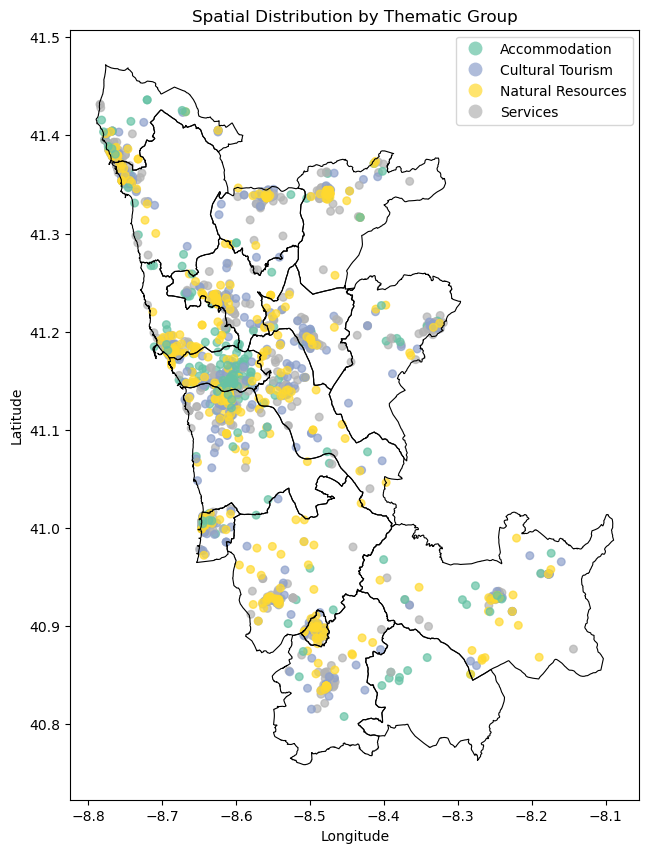

In [18]:
ratings_df = ratings_df.dropna(subset=['Latitude_Nova', 'Longitude_Nova'])

# 2. Criar geometrias corretas
geometry = [Point(xy) for xy in zip(ratings_df['Longitude_Nova'], ratings_df['Latitude_Nova'])]
gdf = gpd.GeoDataFrame(ratings_df, geometry=geometry, crs="EPSG:4326")

# 4. Filtrar pontos que estão dentro da AMP
gdf = gdf[gdf.geometry.within(amp_gdf.unary_union)]

# Traduzir os grupos temáticos para inglês
translate = {
    "Alojamento": "Accommodation",
    "Recursos Naturais": "Natural Resources",
    "Serviços": "Services",
    "Turismo Cultural": "Cultural Tourism",
    "Outro": "Other"
}

gdf["Grupo_Tematico"] = gdf["Grupo_Tematico"].replace(translate)


# 5. Plot com shapefile + pontos
fig, ax = plt.subplots(figsize=(10, 10))
amp_gdf.boundary.plot(ax=ax, color="black", linewidth=0.8)
gdf.plot(column="Grupo_Tematico", legend=True, cmap="Set2", ax=ax, alpha=0.7, markersize=30)

plt.title("Spatial Distribution by Thematic Group")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [19]:
ratings_df.columns

Index(['Cidade', 'Categoria', 'Nome', 'Rating', 'Endereço', 'Tipos',
       'Latitude', 'Longitude', 'Total_Reviews', 'id_unico', 'Grupo_Tematico',
       'Locais_Semelhantes_Perto', 'Latitude_Nova', 'Longitude_Nova',
       'Endereço_Limpo'],
      dtype='object')

In [21]:
comments_df.columns

Index(['Cidade', 'Categoria', 'Nome_Local', 'Autor', 'Texto', 'Data', 'Rating',
       'Idioma', 'Data_Convertida', 'translated_text', 'Texto_Normalizado',
       'Texto_Lematizado', 'Polaridade', 'Polaridade_Média'],
      dtype='object')

In [20]:
# Exportar ratings_df com Latitude_Nova e Longitude_Nova para CSV
ratings_df.to_csv("ratings_geocoded.csv", index=False)